In [1]:
!pip install gluonnlp
!pip install regex

    100% |████████████████████████████████| 245kB 8.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for gluonnlp ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3e/e7/3e/9cdf8ad7fce112fde2f4a52604045e5dd80f84d645bedb70c7
Successfully built gluonnlp
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 655kB 30.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for regex ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Fine-tuning roBERTa


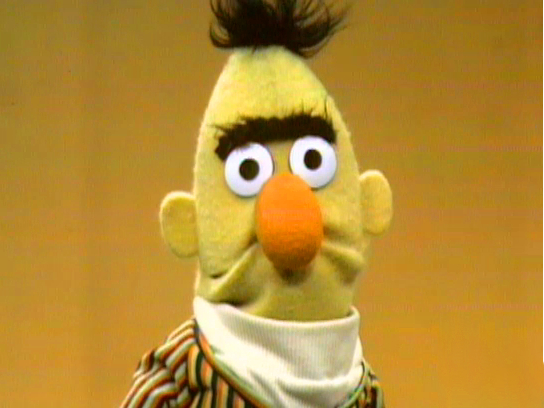

roBERTa (A Robustly Optimized BERT Pretraining Approach - https://arxiv.org/abs/1907.11692) is an implementation of the famous BERT architecture with slight changes to its pre-training method. This allowed Facebook AI to re-obtain the SOTA scores for most NLP benchmarks without extreme changes to the way BERT works. 

Before roBERTa many people thought some change to token masking during pre-training was required to obtain higher scores but roBERTa showed the complicated fixes such as learning bidirectional contexts by maximizing the expected likelihood over all permutations of the factorization order (XLNet: Generalized Autoregressive Pretraining for Language Understanding - https://arxiv.org/abs/1906.08237) or serious scale-ups to 8.3 Billion parameters such as in NVIDIA's Megatron-LM (https://github.com/nvidia/megatron-lm) were actually not required.

roBERTa innovates in a few ways:
1. training the model longer, with bigger batches, over more data
2. removing the next sentence prediction objective
3. training on longer sequences
4. dynamically changing the masking pattern applied to the training data.

Through this they managed to beat classic BERT on the same training set, and beat other, newere LMs on a new news corpus (CC-NEWS).


This notebook will try to demistify fine-tuning roBERTa (and similarly other big language models) by using the extreme flexibility of GluonNLP.

# Setup

In [1]:
# Setup
import sys
import os
import mxnet as mx
import gluonnlp as nlp

import re
import time
import multiprocessing as mp

import numpy as np
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import Block, nn

## Hyperparameter setup

In [2]:
# Hyperparameter setup
envs = {
        # context
        'ctx': 'gpu',

        # data vars
        'max_len': 500,
        'all_labels': [0,1],
        'workers': 20,

        # trainer vars
        'lr': 5e-6,
        'num_epochs': 2,
        'batch_size': 32,
        'log_interval': 50,
        'grad_clip': 1,
    }

## quickly setup context settings based on environment

In [3]:
# quickly setup context settings based on environment
if envs['ctx'] == 'cpu':
        envs['ctx'] = mx.cpu(0)
elif envs['ctx'] == 'gpu':
    if mx.context.num_gpus() > 1:
        envs['ctx'] = [mx.gpu(i) for i in range(mx.context.num_gpus())]
    else:
        envs['ctx'] = mx.gpu(0)

In [4]:
print(envs['ctx'])

[gpu(0), gpu(1), gpu(2), gpu(3)]


# Defining a model

In [5]:
class ROBERTAClassifier(Block):
    def __init__(self, roberta, num_classes=2, hidden_size=256, dropout=0.2, prefix=None, params=None):
        super(ROBERTAClassifier, self).__init__(prefix=prefix, params=params)
        self.robert = roberta

        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            self.classifier.add(nn.Dense(units=hidden_size))
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

    def forward(self, inputs, valid_length=None):
        out = self.robert(inputs, valid_length)
        
        return self.classifier(out)

## 1. Get roBERTa

In [6]:
def get_pretrained_model(ctx):
    model, vocab = nlp.model.get_model('roberta_12_768_12',
                                       dataset_name='openwebtext_ccnews_stories_books_cased',
                                       pretrained=True, ctx=ctx, use_pooler=True,
                                       use_decoder=False, use_classifier=False)
    return model, vocab

# call the functions
roberta, vocabulary = get_pretrained_model(envs['ctx'])

## 2. Create the model for sentiment analysis

In [7]:
roberta_classifier = ROBERTAClassifier(roberta, 
                                       num_classes=2, 
                                       hidden_size=256, 
                                       dropout=0.2, 
                                       prefix=None, 
                                       params=None)
    
roberta_classifier.classifier.initialize(init=mx.init.Xavier(), 
                                         ctx=envs['ctx'])

# Data preprocessing for roBERTa

## 1. Obtain dataset

Let's setup some quick helper functions.

In [15]:
def load_data():
    train_dataset, test_dataset = [nlp.data.IMDB(root='data/imdb', segment=segment) for segment in ('train', 'test')]
    return train_dataset, test_dataset

def setup_tokenizer():
    tokenizer = nlp.data.GPT2BPETokenizer()
    return tokenizer

def process_label(x):
    data, label = x
    # Label is a review score from 1 to 10. We take 6..10 as a positive sentiment
    # and 1..5 as a negative
    label = int(label > 5)
    return [data, label]


One method to process the dataset.

In [16]:
def process_dataset(dataset):
    start = time.time()
    with mp.Pool() as pool:
        # Each sample is processed in an asynchronous manner.
        dataset = gluon.data.SimpleDataset(pool.map(process_label, dataset))
    end = time.time()
    print('Done! Label processing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset

## 2. Transform labels and setup tokenizer

In [21]:
train_dataset, test_dataset = load_data()
train_dataset = process_dataset(train_dataset)
test_dataset = process_dataset(test_dataset)

tokenizer = setup_tokenizer()

Done! Label processing Time=3.34s, #Sentences=25000
Done! Label processing Time=3.37s, #Sentences=25000


## 3. roBERTa dataset class

In [22]:
# roBERTa dataset class

class ROBERTADatasetTransform:
    def __init__(self, vocab, tokenizer, max_seq_length, pad=True, pair=True):
        self._vocab = vocab
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._clip = nlp.data.ClipSequence(max_seq_length - 2)

    def __call__(self, line):
        tokens = self._tokenizer(line[0])
        tokens = self._clip(tokens)
        tokens = [self._vocab.bos_token] + tokens + [self._vocab.eos_token]

        indexed = self._vocab[tokens]
        valid_length = len(indexed)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            indexed.extend([self._vocab[self._vocab.padding_token]] * padding_length)

        return mx.nd.array(indexed), valid_length, line[1]

Let's setup the ROBERTA dataset transformer and build dataloaders.

In [23]:
def instantiate_data_pipeline(train_dataset, 
                              test_dataset, 
                              vocab, 
                              tokenizer, 
                              envs):
    
    rob_transformer = ROBERTADatasetTransform(vocab, 
                                              tokenizer, 
                                              envs['max_len'],
                                              pad=True)
    
    data_train = train_dataset.transform(rob_transformer)
    data_test = test_dataset.transform(rob_transformer)
    
    train_dataloader = mx.gluon.data.DataLoader(data_train,
                                                batch_size=envs['batch_size'], shuffle=True,
                                                num_workers=envs['workers'])
    test_dataloader = mx.gluon.data.DataLoader(data_test, 
                                               batch_size=envs['batch_size'], shuffle=False,
                                               num_workers=envs['workers'])

    return data_train, data_test, train_dataloader, test_dataloader

And run it on the preprocessed datasets.

In [24]:
data_train, data_test, train_loader, test_loader = instantiate_data_pipeline(train_dataset, 
                                                                              test_dataset,
                                                                              vocabulary, 
                                                                              tokenizer, 
                                                                              envs)

Process ForkPoolWorker-157:
Process ForkPoolWorker-161:
Process ForkPoolWorker-162:
Process ForkPoolWorker-164:
Process ForkPoolWorker-145:
Process ForkPoolWorker-155:
Process ForkPoolWorker-143:
Process ForkPoolWorker-153:
Process ForkPoolWorker-168:
Process ForkPoolWorker-158:
Process ForkPoolWorker-138:
Process ForkPoolWorker-147:
Process ForkPoolWorker-163:
Process ForkPoolWorker-159:
Process ForkPoolWorker-151:
Process ForkPoolWorker-146:
Process ForkPoolWorker-152:
Process ForkPoolWorker-148:
Process ForkPoolWorker-160:
Process ForkPoolWorker-167:
Process ForkPoolWorker-165:
Process ForkPoolWorker-144:
Process ForkPoolWorker-141:
Process ForkPoolWorker-156:
Process ForkPoolWorker-154:
Process ForkPoolWorker-149:
Process ForkPoolWorker-150:
Process ForkPoolWorker-139:
Process ForkPoolWorker-140:
Process ForkPoolWorker-142:
Process ForkPoolWorker-166:
Process ForkPoolWorker-137:
Process ForkPoolWorker-133:
Process ForkPoolWorker-136:
Process ForkPoolWorker-131:
Process ForkPoolWork

In [25]:
sample_id = 5
print('vocabulary used for tokenization = \n%s' % vocabulary)
print('%s token id = %s' % (vocabulary.padding_token, vocabulary[vocabulary.padding_token]))
print('token ids = \n%s' % data_train[sample_id][0][:100])
print('valid length = \n%s' % data_train[sample_id][1])
print('label = \n%s' % data_train[sample_id][2])

vocabulary used for tokenization = 
Vocab(size=50265, unk="<unk>", reserved="['<mask>', '<pad>', '<s>', '</s>']")
<pad> token id = 1
token ids = 

[0.0000e+00 7.1300e+02 9.6500e+02 7.5000e+01 5.0000e+00 2.9045e+04
 8.4720e+03 1.6040e+03 6.0000e+00 3.4860e+03 1.6000e+01 2.4000e+01
 5.0000e+00 2.2364e+04 7.3000e+01 1.3440e+03 1.7280e+03 8.4720e+03
 1.6040e+03 9.0000e+00 4.8500e+02 1.4481e+04 9.4440e+03 4.0000e+00
 1.5200e+02 1.6000e+01 1.0000e+01 9.2840e+03 9.0000e+00 5.0000e+00
 4.1870e+03 4.1490e+03 3.9600e+02 8.1000e+01 1.2000e+01 4.1700e+02
 4.0400e+03 4.1500e+02 1.9380e+03 6.0000e+00 4.2810e+03 1.9000e+01
 8.4720e+03 1.8000e+01 9.2000e+01 6.5700e+02 9.0000e+00 5.0000e+00
 1.4481e+04 4.0000e+00 1.2500e+02 4.2000e+01 9.6500e+02 7.5000e+01
 1.0000e+01 1.4481e+04 6.0000e+00 2.2800e+02 8.4200e+02 4.0000e+00
 1.5200e+02 1.6000e+01 5.5000e+01 1.0000e+01 9.0010e+03 7.3000e+01
 3.2658e+04 9.4010e+03 1.1550e+03 1.4900e+02 6.1000e+01 1.6040e+03
 3.8810e+03 7.0000e+00 1.2982e+04 1.0000e+01 4.73

## Fine-tuning the model

Now we have all the pieces to put together, and we can finally start fine-tuning the
model with very few epochs. For demonstration, we use a fixed learning rate and
skip the validation steps. For the optimizer, we leverage the ADAM optimizer which
performs very well for NLP data and for BERT models in particular.

## 1. Setting up trainer and loss

In [28]:
trainer = mx.gluon.Trainer(roberta_classifier.collect_params(), 
                           'adam', 
                           {'learning_rate': envs['lr'], 
                            'epsilon': 1e-9}, 
                           update_on_kvstore=False)

loss_function = mx.gluon.loss.SoftmaxCELoss()

## 2. Creating evaluate function

In [29]:
def evaluate(model, dataloader, loss_function, ctx):
    metric = mx.metric.Accuracy()
    step_loss = 0
    
    for batch_id, (token_ids, valid_length, label) in enumerate(dataloader):
        token_ids = token_ids.as_in_context(ctx[0])
        valid_length = valid_length.as_in_context(ctx[0]).astype('float32')
        label = label.as_in_context(ctx[0])

        out = model(token_ids, valid_length)
        ls = loss_function(out, label).mean()

        step_loss += ls.asscalar()
        metric.update([label], [out])

    return metric.get()[1], step_loss / len(dataloader)

## 3. Defining training function

In [30]:
def train(model, train_dataloader, test_dataloader, trainer, loss_function, envs):
    metric = mx.metric.Accuracy()
    # Collect all differentiable parameters for gradient clipping
    params = [p for p in model.collect_params().values() if p.grad_req != 'null']
    t0 = time.time()
    
    for epoch_id in range(envs['num_epochs']):
        metric.reset()
        step_loss = 0
        for batch_id, (token_ids, valid_length, label) in enumerate(train_dataloader):
            token_ids = mx.gluon.utils.split_and_load(token_ids, 
                                                      ctx_list=envs['ctx'], 
                                                      even_split=False)
            valid_lengths = mx.gluon.utils.split_and_load(valid_length.astype('float32'), 
                                                          ctx_list=envs['ctx'], 
                                                          even_split=False)
            labels = mx.gluon.utils.split_and_load(label, 
                                                   ctx_list=envs['ctx'], 
                                                   even_split=False)

            with mx.autograd.record():
                outs = [model(token_ids_slice, valid_length_slice.astype('float32')) 
                        for (token_ids_slice, valid_length_slice) in zip(token_ids, valid_lengths)]
                lss = [loss_function(out_slice, label_slice).mean() for (out_slice, label_slice) in zip(outs, labels)]
            
            losses = []
            for loss in lss:
                loss.backward()  
                losses.append(loss.asscalar())
                
            mean_loss = np.mean(losses)

            trainer.allreduce_grads()
            nlp.utils.clip_grad_global_norm(params, 1)
            trainer.update(1)

            step_loss += mean_loss
            
            for (label_slice, out_slice) in zip(labels, outs):
                metric.update([label_slice], [out_slice])

            if (batch_id + 1) % (envs['log_interval']) == 0:
                tt = time.time()- t0
                print('[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} in {} seconds'
                             .format(epoch_id, batch_id + 1, len(train_dataloader),
                                     step_loss / envs['log_interval'], trainer.learning_rate, metric.get()[1], tt))
                step_loss = 0
                t0 = time.time()
                
        
        t0 = time.time()
        test_acc, test_loss = evaluate(model, test_dataloader, loss_function, envs['ctx'])
        t1 = time.time() - t0
        print('[Epoch {}] test_loss={:.4f}, test_acc={:.3f} in {} seconds'
             .format(epoch_id, test_loss, test_acc, t1))

## 4.Training the model
Finally we can start fine-tuning! Remember, we setup hyperparameters at the start - be careful with batch-size, with single GPU you can only do ~10 examples per batch while with 4 GPUs 32 is doable.

In [31]:
envs

{'ctx': [gpu(0), gpu(1), gpu(2), gpu(3)],
 'max_len': 500,
 'all_labels': [0, 1],
 'workers': 20,
 'lr': 5e-06,
 'num_epochs': 2,
 'batch_size': 32,
 'log_interval': 50,
 'grad_clip': 1}

In [32]:
train(roberta_classifier, 
      train_loader,
      test_loader, 
      trainer, 
      loss_function,
      envs)

[Epoch 0 Batch 50/782] loss=0.5401, lr=0.0000050, acc=0.714 in 39.44321846961975 seconds
[Epoch 0 Batch 100/782] loss=0.3058, lr=0.0000050, acc=0.803 in 35.46804690361023 seconds
[Epoch 0 Batch 150/782] loss=0.2728, lr=0.0000050, acc=0.836 in 35.31824517250061 seconds
[Epoch 0 Batch 200/782] loss=0.2050, lr=0.0000050, acc=0.859 in 35.27818489074707 seconds
[Epoch 0 Batch 250/782] loss=0.2052, lr=0.0000050, acc=0.874 in 35.42699313163757 seconds
[Epoch 0 Batch 300/782] loss=0.2726, lr=0.0000050, acc=0.881 in 35.04983854293823 seconds
[Epoch 0 Batch 350/782] loss=0.1949, lr=0.0000050, acc=0.888 in 34.946404457092285 seconds
[Epoch 0 Batch 400/782] loss=0.2517, lr=0.0000050, acc=0.891 in 35.258734703063965 seconds
[Epoch 0 Batch 450/782] loss=0.1845, lr=0.0000050, acc=0.896 in 35.35358715057373 seconds
[Epoch 0 Batch 500/782] loss=0.2413, lr=0.0000050, acc=0.898 in 34.90401220321655 seconds
[Epoch 0 Batch 550/782] loss=0.1947, lr=0.0000050, acc=0.901 in 34.357885122299194 seconds
[Epoch 0

KeyboardInterrupt: 

## 5. Setup inference

In [33]:
def run_inference(model, test_text, vocab, envs):
    if len(envs['ctx']) > 1:
        ctx = envs['ctx'][0]
    else:
        ctx = envs['ctx']

    tokenizer = setup_tokenizer()

    # setup pretrained models
    print('setting up transformer...')
    transformer = ROBERTADatasetTransform(vocab, 
                                          tokenizer,
                                          envs['max_len'],
                                          pad=True,
                                          pair=False)
    
    r_text = (test_text, 1)
    
    s = transformer(r_text)

    sequence = s[0].as_in_context(envs['ctx'][0]).reshape(1, -1)
    valid_len = mx.nd.array(s[1]).reshape(1,).as_in_context(mx.gpu(0))
    
    print('running inference..\n')
    positive_review_probability = model(sequence, valid_len ).softmax()
    print('"{}" is {:.1f}% likely to be positive'.format(
        r_text[0], 100 * positive_review_probability[0][1].asscalar()))

## 6. Predict using model

In [34]:
text = 'I would like to say something positive about this movie, and I can\'t'

run_inference(roberta_classifier, text, vocabulary, envs)

setting up transformer...
running inference..

"I would like to say something positive about this movie, and I can't" is 16.9% likely to be positive
